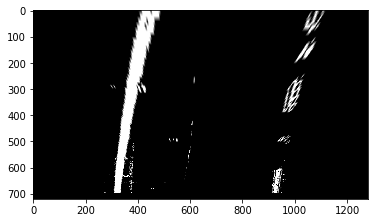

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('examples/warped_binary.png')[:,:,0]
plt.imshow(binary_warped,cmap='gray')

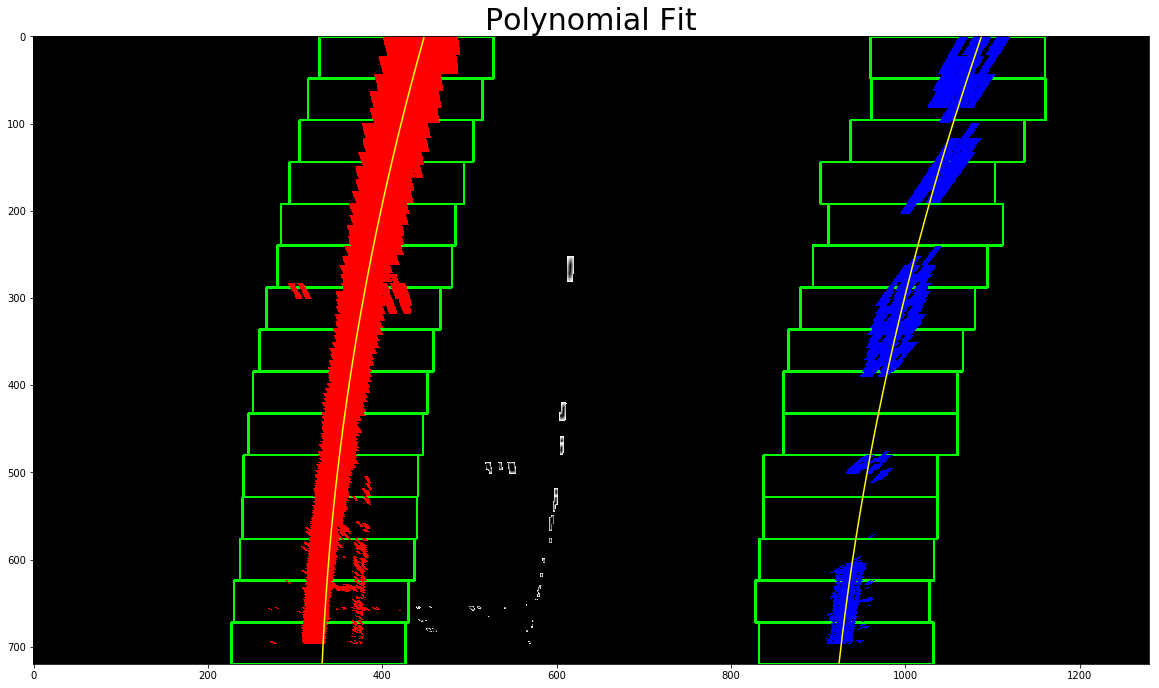

In [3]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[3*binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high =leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img*255, left_fitx, right_fitx, ploty


out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

f, ax1 = plt.subplots(1, 1, figsize=(20,20))

ax1.imshow(out_img)
# Plots the left and right polynomials on the lane lines
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')

ax1.set_title('Polynomial Fit', fontsize=30)


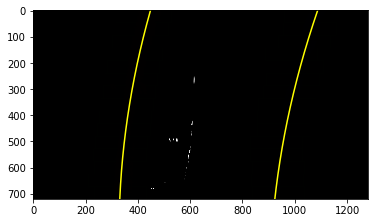

In [29]:
def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Set the width of the window
    conv_kernel_width = 50 
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Draw the levels on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ## If you found > minpix pixels, recenter next level ###
        if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
            
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(conv_kern, image_layer)
        
            if len(good_left_inds) > minpix:
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset


            if len(good_right_inds) > minpix:
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            leftx_current = l_center
            rightx_current = r_center
    
    # end level loop
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

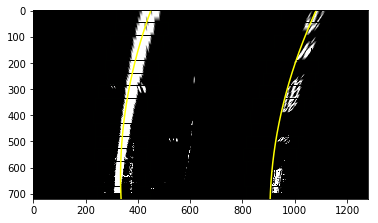

In [16]:
## what if instead I fit the poly only on the centroids?

def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Set the width of the window
    conv_kernel_width = margin 
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]//4):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane = []
    right_lane = []
    y = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Draw the levels on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            
        image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
        conv_signal = np.convolve(conv_kern, image_layer)

        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset

        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
           
        # Append these points to the lists
        left_lane.append(l_center)
        right_lane.append(r_center)
        y.append( ( win_y_low + win_y_high )/2. )
            
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        leftx_current = l_center
        rightx_current = r_center
    
    # end level loop
            
    return left_lane, y, right_lane, y, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]
    # doesn't make sense for just one piont per window and moreover is not working, so ...

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

## Good this in way more stable!

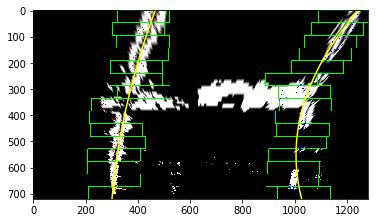

In [5]:
from random import sample

# I think tough ultimately just one point is sketchy... maybe I can do a subsampling, so that each window
# contribute equally to the result

def find_lane_pixels(binary_warped):

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set the width of the window
    conv_kernel_width = margin//4
    conv_kern = np.ones(conv_kernel_width) # Create our window template that we will use for convolutions
    offset = conv_kernel_width/2
    
    # Sum quarter bottom of image to get slice
    l_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,:int(binary_warped.shape[1]//2)], axis=0) 
    l_center = np.argmax(np.convolve(conv_kern,l_sum))-conv_kernel_width/2 ## we find the peak/center by argmaxing the convolved hist
    
    r_sum = np.sum(binary_warped[int(1*binary_warped.shape[0]//2):,int(binary_warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(conv_kern,r_sum))-conv_kernel_width/2+int(binary_warped.shape[1]/2)
    
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = l_center
    rightx_current = r_center

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the levels one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (level+1)*window_height
        win_y_high = binary_warped.shape[0] - level*window_height
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)

        # Draw the levels on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] ## nonzero here is sort of working as a "which"? [0] is needed to return only the first coord (Xs)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
  
        ## If you found > minpix pixels, recenter next level ###
        if len(good_left_inds) >= minpix or len(good_right_inds) >= minpix:  # could be ==
            
            image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(conv_kern, image_layer)
        
            if len(good_left_inds) >= minpix:
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                
                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_left_inds) >= 2*minpix:
                    good_left_inds = good_left_inds[sample( k=2*minpix , population=range(len(good_left_inds)) )]


            if len(good_right_inds) >= minpix:
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

                # do a subsampling in case there are too many to skew the result too much in favor of this window
                if len(good_right_inds) >= 2*minpix:
                    good_right_inds = good_right_inds[sample( k=2*minpix , population=range(len(good_right_inds)) )]
                
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
            leftx_current = l_center
            rightx_current = r_center
            
        # Append these indices to the lists
        left_lane_inds.append( good_left_inds )
        right_lane_inds.append( good_right_inds )

    
    # end level loop
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) ## x and y reversed because in the image that's the idea

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)